# Bayesian analysis of the second MTurk Experiment (sep 2018)

In [1]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sb
import pymc3 as pm

import theano.tensor as tt
from theano.compile.ops import as_op

from scipy.stats import norm
from scipy.stats import t as studentT

from matplotlib import gridspec
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from IPython.display import Image

%matplotlib inline
plt.style.use('seaborn-white')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Gill Sans MT']

from matplotlib import rc
# # Use LaTeX for typesetting
# rc('text', usetex=True)
# # Use ACM standard fonts (Type 1) for numbers and labels
# rc('text.latex',
#    preamble=[
#        r'\usepackage[tt=false, type1=true]{libertine}',
#        r'\usepackage[libertine]{newtxmath}', r'\usepackage[varqu]{zi4}',
#        r'\usepackage[T1]{fontenc}'
#    ])

/Users/harisundaram/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
line_color = np.array([138, 175, 197]) / 255.0

In [3]:
line_color

array([0.54117647, 0.68627451, 0.77254902])

# Data

In [4]:
# Using dtype 'category' for Y

df = pd.read_csv(
    'data/cs_final.csv'
#     dtype={
#         'y': 'int',
#         'gesture': 'int',
#         'dist': 'int',
#         'shading': 'int',
#         'cond': 'int',
#         'comicleft': 'int'
#     }
)

df.rename(columns={'text_donation':'text', 'comic_donation':'comic', 'socialnorm_donation': 'social'}, inplace=True)
# df.info()
dfs = pd.DataFrame()

In [5]:
# Calculate Gamma shape and rate from mode and sd.
# if using gamma prior for the class dependent sigma

def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

## converting everything to a simple data format

In [6]:
t = pd.DataFrame()
tmp = df[df.text>=0] # adding text data
dfs['response'] = tmp.text
dfs['condition'] = 0

tmp = df[df.comic>=0].comic # adding comic data
t['response'] = tmp
t['condition'] = 1
dfs = pd.concat([dfs, t])


t2 = pd.DataFrame()
tmp = df[df.social>=0].social # adding comic social norm data
t2['response'] = tmp
t2['condition'] = 2
dfs = pd.concat([dfs, t2])

In [7]:
np.std(dfs[dfs.condition==0].response)

1.5136413811975737

In [8]:
np.std(dfs[dfs.condition==1].response)

1.8490133532208042

In [9]:
# doing all three cases together
m_mean = np.zeros(3)
m_mean[0] = np.mean(dfs[dfs.condition==0].response)
m_mean[1] = np.mean(dfs[dfs.condition==1].response)
m_mean[2] = np.mean(dfs[dfs.condition==2].response)

m_std = np.zeros(3)
m_std[0] = np.std(dfs[dfs.condition==0].response)
m_std[1] = np.std(dfs[dfs.condition==1].response)
m_std[2] = np.std(dfs[dfs.condition==2].response)

In [10]:
dfs2 = dfs.copy()
dfs2.condition[dfs2.condition==0] = "text"
dfs2.condition[dfs2.condition==1] = "comic"
dfs2.condition[dfs2.condition==2] = "comic+social"

/Users/harisundaram/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/Users/harisundaram/miniconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


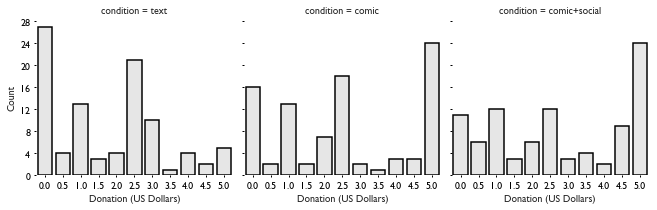

In [11]:
g = sb.FacetGrid(data=dfs2, col="condition")
g.map(
    sb.countplot,
    "response",
    linewidth=1.5,
    facecolor='0.9',
    edgecolor='k'
).set(yticks=np.arange(0, 30, 4)).set_axis_labels("Donation (US Dollars)", "Count")
g.axes[0,0].tick_params(
    direction='out', length=2, width=1, colors='k', which='major')
g.axes[0,1].tick_params(
    direction='out', length=2, width=1, colors='k', which='major')
g.axes[0,2].tick_params(
    direction='out', length=2, width=1, colors='k', which='major')
g.despine(offset=20, left=True, bottom=True)
g.savefig("contributions across conditions.pdf")

In [12]:
list(set(dfs.response))

[0.0, 1.5, 2.5, 2.0, 3.0, 1.0, 4.5, 4.0, 0.5, 5.0, 3.5]

## Defining the model

We have two different groups, who are randomly assigned to the control and treatment groups. The outcome variable is the degree of contribution. We model it as a student-t distribution; the number of degrees of freedom is obtained from an exponential distribution $\nu \sim \exp(-\lambda)$; the mode $\mu \sim \mathcal{N}(a,b)$, spread $\sigma \sim U(L,H)$



We have two different groups, who are randomly assigned to the control and treatment groups. The outcome variable is the degree of contribution. We model it as a beta distribution, since the response variable is bounded; the two parameters $(\alpha, \beta)$ are modeled to be drawn from an exponential distribution



## model code (sep. 2018)

In [13]:
n_lambda = 1/29.0  # hyperprior parameter for nu
# m_mean = dfs.groupby('condition').mean().values
# m_sigma = dfs.groupby('condition').std().values


s_low = 0
s_high = 5
# case = dfs[dfs.condition < 2].condition # either 0, 1
# obs  = dfs[dfs.condition < 2].response # for conditions 0, 1

case = dfs.condition # either 0, 1, 2
obs  = dfs.response # for conditions 0, 1, 2
# obs  = 0.0001+0.999*(dfs.response)/5.0 # normalized response for conditions 0, 1, 2

with pm.Model() as group_main:

    mode = pm.Normal('mode', mu=m_mean/5.0, tau=1 / m_std**2, shape=3, testval=m_mean)
    deg_nu = pm.Exponential('nu', lam=n_lambda)  # shared
    sigma = pm.Uniform('sigma', lower=0, upper=5, shape=3)

    r = pm.StudentT('R_obs', observed=obs, nu=deg_nu, mu=mode[case], sd=sigma[case])

## model code (beta, feb. 2019)

In [14]:
# n_lambda = 10.0 # hyperprior parameter for the exponential distribution

# s_low = 0
# s_high = 5
# # case = dfs[dfs.condition < 2].condition # either 0, 1
# # obs  = dfs[dfs.condition < 2].response # for conditions 0, 1

# case = dfs.condition # either 0, 1, 2
# obs  = 0.0001+0.999*(dfs.response)/5.0 # normalized response for conditions 0, 1, 2

# with pm.Model() as group_main:
#     a = pm.Exponential('alpha', lam=n_lambda, shape=3, testval=1) # the alpha parameter
#     b = pm.Exponential('beta', lam=n_lambda, shape=3, testval=1) # the beta parameter
    
# #     mode = pm.Normal('mode', mu=m_mean, tau=1 / m_std**2, shape=3)    
# #     sigma = pm.Uniform('sigma', lower=0, upper=5, shape=3)

# #     r = pm.Normal('R_obs',  observed=obs, mu=mode[case], sd=sigma[case])

#     r = pm.Beta('R_obs', observed=obs, alpha=a[case], beta=b[case])

In [15]:
with group_main:
    trace = pm.sample(20000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, nu, mode]
Sampling 4 chains: 100%|██████████| 82000/82000 [01:21<00:00, 1008.86draws/s]


## diagnostics

In [16]:
print(pm.diagnostics.gelman_rubin(trace))
print("effective sample size", pm.diagnostics.effective_n(trace))

{'mode': array([0.99998846, 0.99997709, 0.99999747]), 'nu': 1.0000010266394743, 'sigma': array([0.99999484, 1.00002112, 0.99999273])}
effective sample size {'mode': array([92549.73857999, 85665.25204041, 91698.55958127]), 'nu': 81252.22663863543, 'sigma': array([96738.27653386, 77490.92948173, 84627.83795856])}


In [17]:
# import pickle #

# with open('ordinal_factor_model_main-noint.pkl', 'wb') as buff:
#     pickle.dump({'model': ordinal_factor_model_main, 'trace': trace}, buff)

# with open('my_model.pkl', 'rb') as buff:
#     data = pickle.load(buff)  

# basic_model, trace = data['model'], data['trace']

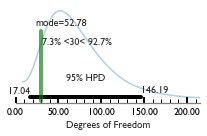

In [18]:
# checking normality

fig, axs = sb.mpl.pyplot.subplots(1, 1)  #### change on changing parameters
fig.set_size_inches(3, 2)

pm.plot_posterior(
    trace['nu'],
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ref_val=30,
    text_size=10,
    ax=axs)

z = axs
# s = "$\mu$"
z.set_xlabel("Degrees of Freedom")

center = trace['nu'].mean()
z.set_xlim([0, 3*center])
z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
z.xaxis.set_ticks_position('bottom')
# z.yaxis.set_ticks_position('left')
z.minorticks_on()

fig.tight_layout()
fig.savefig("normality parameter.pdf")


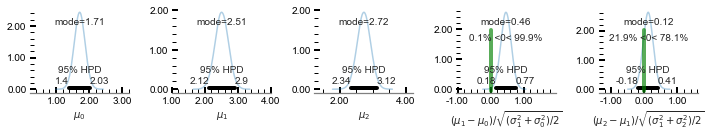

In [19]:
mode = trace['mode']
# nm = (b0 - 4) / sigma  # effect size

# plot theta posterior

NRows = 1  
NCols = 5  # three basic plots and two effect sizes
sb.set_style("white")
fig3, axs3 = sb.mpl.pyplot.subplots(NRows,
                                    NCols)  #### change on changing parameters
fig3.set_size_inches(NCols * 2, 2)

# Plot three posteriors
pm.plot_posterior(
    trace['mode'][:, 0],
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ax=axs3[0],
    text_size=10)
pm.plot_posterior(
    trace['mode'][:, 1],
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ax=axs3[1],
    text_size=10)
pm.plot_posterior(
    trace['mode'][:, 2],
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ax=axs3[2],
    text_size=10)


# determining the effect size

mu0 = trace['mode'][:, 0]
mu1 = trace['mode'][:, 1]
mu2 = trace['mode'][:, 2]

sigma0 = trace['sigma'][:, 0]
sigma1 = trace['sigma'][:, 1]
sigma2 = trace['sigma'][:, 2]



effect10 = (mu1 - mu0)/np.sqrt((sigma0**2 + sigma1**2)/2.0)
effect21 = (mu2 - mu1)/np.sqrt((sigma1**2 + sigma2**2)/2.0)



for j in range(3):
    z = axs3[j]
    s = "$\\mu_{{{0}}}$".format(j)
    z.set_xlabel("{0}".format(s))
    center = trace['mode'][:, j].mean()
    z.set_xlim([center - 1.5, center + 1.5])

    z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
    z.xaxis.set_ticks_position('bottom')
    z.yaxis.set_ticks_position('left')
    z.minorticks_on()


# first contrast: comic vs. text
pm.plot_posterior(
    effect10,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ref_val=0,
    ax=axs3[3],
    text_size=10)

z = axs3[3]
s = "$ (\mu_1 - \mu_0)/\sqrt{(\sigma_1^2 + \sigma_0^2)/2}$"
z.set_xlabel("{0}".format(s))
center = effect10.mean()
z.set_xlim([center - 1.5, center + 1.5])

z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
z.xaxis.set_ticks_position('bottom')
z.yaxis.set_ticks_position('left')
z.minorticks_on()


# second contrast: comic vs. social
pm.plot_posterior(
    effect21,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ref_val=0,
    ax=axs3[4],
    text_size=10)

z = axs3[4]
s = "$ (\mu_2 - \mu_1)/\sqrt{(\sigma_1^2 + \sigma_2^2)/2}$"
z.set_xlabel("{0}".format(s))
center = effect21.mean()
z.set_xlim([center - 1.5, center + 1.5])

z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
z.xaxis.set_ticks_position('bottom')
z.yaxis.set_ticks_position('left')
z.minorticks_on()




fig3.tight_layout()
fig3.savefig("new_exp_text_v_comic_v_social.pdf")


In [ ]:
pm.plot_posterior(
    sigma0,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    text_size=10)
pm.plot_posterior(
    sigma1,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    text_size=10)
pm.plot_posterior(
    sigma2,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    text_size=10)

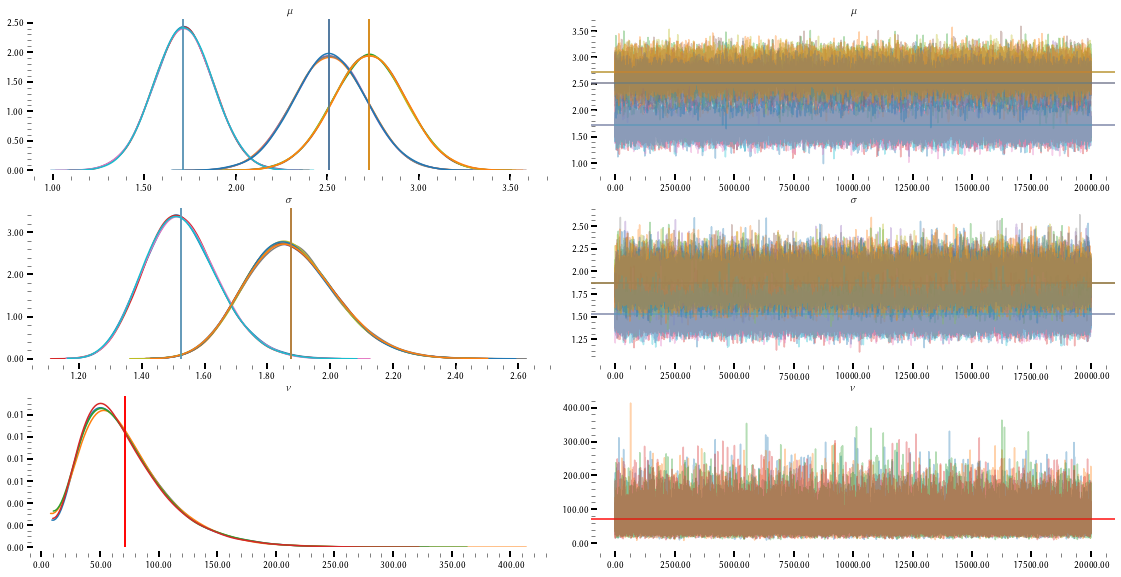

In [22]:
# Use LaTeX for typesetting
rc('text', usetex=True)
# Use ACM standard fonts (Type 1) for numbers and labels
rc('text.latex',
   preamble=[
       r'\usepackage[tt=false, type1=true]{libertine}',
       r'\usepackage[libertine]{newtxmath}', 
       r'\usepackage[varqu]{zi4}',
       r'\usepackage[T1]{fontenc}'
   ])

NRows = 3
NCols = 2
fig, axs = sb.mpl.pyplot.subplots(3, 2)
fig.set_size_inches(16, 8)
pm.plots.traceplot(
    trace=trace,
    varnames=['mode', 'sigma', 'nu'],
    ax=axs,
    lines={
        'mode': [mu0.mean(), mu1.mean(), mu2.mean()],
        'sigma': [sigma0.mean(), sigma1.mean(), sigma2.mean()],
        'nu': (trace['nu']).mean()
        }
    )

for i in range(NRows):
    for j in range(NCols):
        z = axs[i, j]
        z.set_xlabel("") # no individual labels
        z.set_ylabel("")
        z.spines['right'].set_visible(False)
        z.spines['top'].set_visible(False)
        z.spines['left'].set_visible(False)
        z.spines['bottom'].set_visible(False)
        z.spines['bottom'].set_position(('outward', 10))
        z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
        z.tick_params(direction='in', length=4, width=1, colors='gray', which='minor')
        z.minorticks_on()
        
axs[0,0].set_title(r'$\mu$')
axs[0,1].set_title(r'$\mu$')
axs[1,0].set_title(r'$\sigma$')
axs[1,1].set_title(r'$\sigma$')
axs[2,0].set_title(r'$\nu$')
axs[2,1].set_title(r'$\nu$')
fig.savefig('traceplot.pdf')


## using the Beta distribution (feb. 2019).

we need to transform the variables into mean and variance; $$\mu = \frac{\alpha}{\alpha + \beta}$$ and variance $$\sigma = \frac{\alpha \beta}{(\alpha + \beta)^2 (\alpha + \beta +1)}$$



In [ ]:
# determining the parameters first

alpha0 = trace['alpha'][:, 0]
alpha1 = trace['alpha'][:, 1]
alpha2 = trace['alpha'][:, 2]

beta0 = trace['beta'][:, 0]
beta1 = trace['beta'][:, 1]
beta2 = trace['beta'][:, 2]


# transforming them

mu0 = alpha0 / (alpha0 + beta0)
mu1 = alpha1 / (alpha1 + beta1)
mu2 = alpha2 / (alpha2 + beta2)

sigma0 = (alpha0 * beta0) / ((alpha0 + beta0)**2 * (alpha0 + beta0 +1))
sigma1 = (alpha1 * beta1) / ((alpha1 + beta1)**2 * (alpha1 + beta1 +1))
sigma2 = (alpha2 * beta2) / ((alpha2 + beta2)**2 * (alpha2 + beta2 +1))

NRows = 1  
NCols = 5  # three basic plots and two effect sizes
sb.set_style("white")
fig3, axs3 = sb.mpl.pyplot.subplots(NRows,
                                    NCols)  #### change on changing parameters
fig3.set_size_inches(NCols * 2, 2)

# Plot three posteriors
pm.plot_posterior(
    mu0,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ax=axs3[0],
    text_size=10)
pm.plot_posterior(
    mu1,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ax=axs3[1],
    text_size=10)
pm.plot_posterior(
    mu2,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ax=axs3[2],
    text_size=10)

effect10 = (mu1 - mu0)/np.sqrt((sigma0**2 + sigma1**2)/2.0)
effect21 = (mu2 - mu1)/np.sqrt((sigma1**2 + sigma2**2)/2.0)


for j in range(3):
    z = axs3[j]
    s = "$\\mu_{{{0}}}$".format(j)
    z.set_xlabel("{0}".format(s))
    z.set_xlim([0, 1])

    z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
    z.xaxis.set_ticks_position('bottom')
    z.yaxis.set_ticks_position('left')
    z.minorticks_on()
    
    
# first contrast: comic vs. text
pm.plot_posterior(
    effect10,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ref_val=0,
    ax=axs3[3],
    text_size=10)

z = axs3[3]
s = "$ (\mu_1 - \mu_0)/\sqrt{(\sigma_1^2 + \sigma_0^2)/2}$"
z.set_xlabel("{0}".format(s))
center = effect10.mean()
z.set_xlim([center - 1.5, center + 1.5])

z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
z.xaxis.set_ticks_position('bottom')
z.yaxis.set_ticks_position('left')
z.minorticks_on()


# second contrast: comic vs. social
pm.plot_posterior(
    effect21,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ref_val=0,
    ax=axs3[4],
    text_size=10)

z = axs3[4]
s = "$ (\mu_2 - \mu_1)/\sqrt{(\sigma_1^2 + \sigma_2^2)/2}$"
z.set_xlabel("{0}".format(s))
center = effect21.mean()
z.set_xlim([center - 1.5, center + 1.5])

z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
z.xaxis.set_ticks_position('bottom')
z.yaxis.set_ticks_position('left')
z.minorticks_on()

fig3.tight_layout()


## using the gamma distribution
avoids the artificial constraints of altering the data

In [ ]:
n_lambda = 1/10.0 # hyperprior parameter for the exponential distribution

s_low = 0
s_high = 5
# case = dfs[dfs.condition < 2].condition # either 0, 1
# obs  = dfs[dfs.condition < 2].response # for conditions 0, 1

case = dfs.condition # either 0, 1, 2
obs  = dfs.response + 0.001 # normalized response for conditions 0, 1, 2

with pm.Model() as group_main:
    a = pm.Exponential('alpha', lam=n_lambda, shape=3, testval=1) # the alpha shape parameter
    b = pm.Exponential('beta', lam=n_lambda, shape=3, testval=1) # the beta rate parameter
    r = pm.Gamma('R_obs', observed=obs, alpha=a[case], beta=b[case])

In [ ]:
with group_main:
    trace = pm.sample(10000)

In [ ]:
# determining the parameters first

alpha0 = trace['alpha'][:, 0]
alpha1 = trace['alpha'][:, 1]
alpha2 = trace['alpha'][:, 2]

beta0 = trace['beta'][:, 0]
beta1 = trace['beta'][:, 1]
beta2 = trace['beta'][:, 2]


# transforming shape and rate to mean and variance

mu0 = alpha0 / beta0
mu1 = alpha1 / beta1
mu2 = alpha2 / beta2

sigma0 = alpha0 / beta0**2
sigma1 = alpha1 / beta1**2
sigma2 = alpha2 / beta2**2

NRows = 1  
NCols = 5  # three basic plots and two effect sizes
sb.set_style("white")
fig3, axs3 = sb.mpl.pyplot.subplots(NRows,
                                    NCols)  #### change on changing parameters
fig3.set_size_inches(NCols * 2, 2)

# Plot three posteriors
pm.plot_posterior(
    mu0,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ax=axs3[0],
    text_size=10)
pm.plot_posterior(
    mu1,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ax=axs3[1],
    text_size=10)
pm.plot_posterior(
    mu2,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ax=axs3[2],
    text_size=10)

effect10 = (mu1 - mu0)/np.sqrt((sigma0**2 + sigma1**2)/2.0)
effect21 = (mu2 - mu1)/np.sqrt((sigma1**2 + sigma2**2)/2.0)


for j in range(3):
    z = axs3[j]
    s = "$\\mu_{{{0}}}$".format(j)
    z.set_xlabel("{0}".format(s))
    z.set_xlim([0, 5])

    z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
    z.xaxis.set_ticks_position('bottom')
    z.yaxis.set_ticks_position('left')
    z.minorticks_on()
    
    
# first contrast: comic vs. text
pm.plot_posterior(
    effect10,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ref_val=0,
    ax=axs3[3],
    text_size=10)

z = axs3[3]
s = "$ (\mu_1 - \mu_0)/\sqrt{(\sigma_1^2 + \sigma_0^2)/2}$"
z.set_xlabel("{0}".format(s))
center = effect10.mean()
z.set_xlim([center - 1.5, center + 1.5])

z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
z.xaxis.set_ticks_position('bottom')
z.yaxis.set_ticks_position('left')
z.minorticks_on()


# second contrast: comic vs. social
pm.plot_posterior(
    effect21,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ref_val=0,
    ax=axs3[4],
    text_size=10)

z = axs3[4]
s = "$ (\mu_2 - \mu_1)/\sqrt{(\sigma_1^2 + \sigma_2^2)/2}$"
z.set_xlabel("{0}".format(s))
center = effect21.mean()
z.set_xlim([center - 1.5, center + 1.5])

z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
z.xaxis.set_ticks_position('bottom')
z.yaxis.set_ticks_position('left')
z.minorticks_on()

fig3.tight_layout()



## differences between comic and comic social

In [ ]:
m_mean = np.zeros(2)
m_mean[0] = np.mean(dfs[dfs.condition==1].response)
m_mean[1] = np.mean(dfs[dfs.condition==2].response)

m_std = np.zeros(2)
m_std[0] = np.std(dfs[dfs.condition==1].response)
m_std[1] = np.std(dfs[dfs.condition==2].response)


n_lambda = 1/29.0  # hyperprior parameter for nu
# m_mean = dfs.groupby('condition').mean().values
# m_sigma = dfs.groupby('condition').std().values


s_low = 0
s_high = 5
case = dfs[dfs.condition > 0].condition - 1 # either 1, 2
obs  = dfs[dfs.condition > 0].response # for conditions 1,2

with pm.Model() as group_comic_v_social:

    mode = pm.Normal('mode', mu=m_mean, tau=1 / m_std**2, shape=2, testval=m_mean)
    deg_nu = pm.Exponential('nu', lam=n_lambda)  # shared
    sigma = pm.Uniform('sigma', lower=0, upper=5, shape=2)


    r = pm.StudentT('R_obs', observed=obs, nu=deg_nu, mu=mode[case], sd=sigma[case])

In [ ]:
with group_comic_v_social:
    trace = pm.sample(10000)

In [ ]:
pm.diagnostics.gelman_rubin(trace)

In [ ]:
pm.traceplot(trace=trace)

In [ ]:
mode = trace['mode']
# nm = (b0 - 4) / sigma  # effect size

# plot theta posterior

NRows = 1  
NCols = 3  # two basic plots and effect size
sb.set_style("white")
fig3, axs3 = sb.mpl.pyplot.subplots(NRows,
                                    NCols)  #### change on changing parameters
fig3.set_size_inches(NCols * 2, 2)

# Plot posteriors
pm.plot_posterior(
    trace['mode'][:, 0],
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ax=axs3[0],
    text_size=10)
pm.plot_posterior(
    trace['mode'][:, 1],
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ax=axs3[1],
    text_size=10)


# determining the effect size

mu0 = trace['mode'][:, 0]
mu1 = trace['mode'][:, 1]

sigma0 = trace['sigma'][:, 0]
sigma1 = trace['sigma'][:, 1]

effect = (mu1 - mu0)/np.sqrt((sigma0**2 + sigma1**2)/2.0)

for j in range(2):
    z = axs3[j]
    s = "$\\mu_{{{0}}}$".format(j)
    z.set_xlabel("{0}".format(s))
    center = trace['mode'][:, j].mean()
    z.set_xlim([center - 1.5, center + 1.5])

    z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
    z.xaxis.set_ticks_position('bottom')
    z.yaxis.set_ticks_position('left')
    z.minorticks_on()


pm.plot_posterior(
    effect,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ref_val=0,
    ax=axs3[2],
    text_size=10)

z = axs3[2]
s = "$ (\mu_1 - \mu_0)/\sqrt{(\sigma_1^2 + \sigma_0^2)/2}$"
z.set_xlabel("{0}".format(s))
center = effect.mean()
z.set_xlim([center - 1.5, center + 1.5])

z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
z.xaxis.set_ticks_position('bottom')
z.yaxis.set_ticks_position('left')
z.minorticks_on()






fig3.tight_layout()
fig3.savefig("new_exp_comic_v_social.pdf")